In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score,f1_score, roc_curve, auc, accuracy_score, confusion_matrix
import shutil


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from model import MeronSmart, ml_models,plot_confusion_matrix

In [3]:
meron = MeronSmart()

In [6]:
dense_model = meron.build_model(task_type='classification')

In [11]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                65632     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total para

In [12]:
merged_df = pd.read_csv('/data/meron/kenya_data/meron_merged_mal(sam_mam_upsampled)_muac.csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')
sam_names=pd.read_csv('/data/meron/sam_photo_ids.csv')
mam_names=pd.read_csv('/data/meron/mam_photo_ids.csv')

#use wfh in meta_data to filter wfh<4
merged_df=merged_df[merged_df['wfh']<4]

In [7]:
merged_df.head()

,photo_id,0,1,2,3,4,5,6,7,8,...,2046,2047,gender_male,age_months,maln_mam,maln_normal,maln_sam,wfh,maln_class,muac_prediction
0,1517384891739.jpg,0.157335,0.015997,0.707683,0.009274,0.000000,0.698504,1.974866,6.329210,0.0,...,1.867832,0.024899,0,32.0,1,0,0,-2.97,mam,normal
1,1517384891739.jpg,0.000000,0.000000,1.571181,0.000000,0.000000,0.627390,1.353355,6.647170,0.0,...,2.161191,0.000000,0,32.0,1,0,0,-2.97,mam,normal
2,1517478268776.jpg,0.045922,0.000000,3.087823,0.000000,0.331306,1.069497,1.636940,1.760356,0.0,...,4.154829,0.812403,1,19.0,1,0,0,-2.09,mam,normal
3,1517478268776.jpg,0.181375,0.000000,3.747156,0.022242,1.065049,1.856126,1.670891,2.034269,0.0,...,3.283012,1.401969,1,19.0,1,0,0,-2.09,mam,normal
4,1517238175403.jpg,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.0,...,2.062518,0.352439,1,18.0,0,1,0,-1.16,normal,normal


# separate the sam samples so duplicates(flipped image) are not distributed evenly in training and test. samples in validation set are not seen in training

In [13]:
sam_samples=merged_df.loc[merged_df['photo_id'].isin(sam_names['photo_id'])]
mam_samples=merged_df.loc[merged_df['photo_id'].isin(mam_names['photo_id'])]

other_samples=merged_df.loc[~merged_df['photo_id'].isin(sam_names['photo_id'])].loc[~merged_df['photo_id'].isin(mam_names['photo_id'])]

In [14]:
print('sam sample size:{}'.format(sam_samples.shape))
print('mam sample size:{}'.format(mam_samples.shape))
print('other sample size:{}'.format(other_samples.shape))

sam sample size:(228, 2057)
mam sample size:(944, 2057)
other sample size:(3019, 2057)


In [15]:
sam_train=sam_samples[:188]
sam_validation=sam_samples[188:]
print('sam training size:{}'.format(sam_train.shape))
print('sam val size:{}'.format(sam_validation.shape))

sam training size:(188, 2057)
sam val size:(40, 2057)


In [16]:
mam_train=mam_samples[:750]
mam_validation=mam_samples[750:]
print('mam training size:{}'.format(mam_train.shape))
print('mam val size:{}'.format(mam_validation.shape))

mam training size:(750, 2057)
mam val size:(194, 2057)


In [17]:
target_sam_train = np.array(sam_train[['maln_mam','maln_normal','maln_sam']])
target_sam_validation=np.array(sam_validation[['maln_mam','maln_normal','maln_sam']])
target_sam_muac_validation=np.array(sam_validation['muac_prediction'])


target_mam_train = np.array(mam_train[['maln_mam','maln_normal','maln_sam']])
target_mam_validation=np.array(mam_validation[['maln_mam','maln_normal','maln_sam']])
target_mam_muac_validation=np.array(mam_validation['muac_prediction'])


target_other=np.array(other_samples[['maln_mam','maln_normal','maln_sam']])
target_other_muac_validation=np.array(other_samples['muac_prediction'])

In [11]:
num_mam = merged_df['maln_mam'].sum()
num_normal = merged_df['maln_normal'].sum()
num_sam = merged_df['maln_sam'].sum()
counts = [num_mam, num_normal, num_sam]
names = ('mam', 'normal','sam')
print('proportion of normal in dataset: {}'.format(num_normal/np.sum(counts)))
print('number of sam: {}'.format(num_sam))
print('number of mam: {}'.format(num_mam))
print('number of normal: {}'.format(num_normal))

proportion of normal in dataset: 0.7146265807683131
number of sam: 232
number of mam: 964
number of normal: 2995


In [18]:
deselect_cols = ['photo_id','maln_mam','maln_normal','maln_sam','wfh','maln_class', 'muac_prediction']

In [19]:
select = [x for x in merged_df.columns if x not in deselect_cols]
sam_train_features = sam_train.loc[:, select]
sam_validation_features = sam_validation.loc[:, select]

mam_train_features = mam_train.loc[:, select]
mam_validation_features = mam_validation.loc[:, select]

other_features=other_samples.loc[:, select]
other_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,gender_male,age_months
4,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.000000,0.0,...,0.687893,0.000000,0.000000,1.743518,0.575827,0.000000,2.062518,0.352439,1,18.0
9,6.018714,0.000000,4.922188,0.250943,3.632266,0.441533,2.783796,9.161777,0.000000,0.0,...,0.000000,0.000000,0.451506,3.653616,0.734750,0.000000,0.000000,0.000000,0,25.0
10,0.302067,0.000000,0.856374,4.006856,0.000000,0.476372,4.314477,11.858264,0.000000,0.0,...,1.534502,0.000000,0.453811,16.605633,0.000000,0.845772,0.506828,0.000000,1,40.0
11,0.000000,0.296940,4.927894,0.212098,0.008911,1.134834,3.333884,2.954910,1.047672,0.0,...,1.352508,0.005078,0.010983,8.271940,0.000000,0.000000,0.876071,0.032372,0,41.0
12,0.000000,0.228124,0.801086,0.476915,1.492239,1.457904,1.052291,18.379776,0.000000,0.0,...,0.005074,0.000000,0.000000,12.780549,0.740513,0.000000,1.912864,1.549561,0,28.0


# Split data into training and testing sets, then train model

In [20]:
whole_data=pd.concat([other_features, sam_train_features, sam_validation_features,mam_train_features,mam_validation_features], axis=0)

In [21]:
### scale/standardize the features?
conv_scaler = StandardScaler().fit(whole_data)
sam_train_features_scaled = conv_scaler.transform(sam_train_features)
sam_validation_features_scaled=conv_scaler.transform(sam_validation_features)

mam_train_features_scaled = conv_scaler.transform(mam_train_features)
mam_validation_features_scaled=conv_scaler.transform(mam_validation_features)

other_features_scaled=conv_scaler.transform(other_features)

In [28]:
### Break data into training and test (stratified)
X_train1, X_test1, y_train1, y_test1 = train_test_split(other_features_scaled, target_other, test_size=0.2, 
                                                        random_state=42, stratify=target_other)

X_train=np.concatenate((X_train1,sam_train_features_scaled,mam_train_features_scaled), axis=0)
y_train=np.concatenate((y_train1,target_sam_train,target_mam_train), axis=0)

X_test=np.concatenate((X_test1,sam_validation_features_scaled,mam_validation_features_scaled), axis=0)
y_test=np.concatenate((y_test1,target_sam_validation, target_mam_validation), axis=0)

In [18]:
### fetch data with muac_prediction, only care about the target for validation
X_train2, X_test2, y_train2, y_test2 = train_test_split(other_samples, target_other, test_size=0.2, 
                                                        random_state=42, stratify=target_other)

#X_test=np.concatenate((X_test1,sam_validation_features_scaled,mam_validation_features_scaled), axis=0)
y_test_muac=np.concatenate((X_test2['muac_prediction'],target_sam_muac_validation, target_mam_muac_validation), axis=0)

In [20]:
print(X_train.shape)
print(X_test.shape)

(3353, 2050)
(838, 2050)


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [22]:
## compute class weight
w = compute_class_weight('balanced', np.unique(merged_df.maln_class), merged_df.maln_class)
w

array([1.44917012, 0.46644407, 6.02155172])

dense_model.compile(loss='categorical_crossentropy',
                               optimizer=Adam(lr=1e-4),
                               metrics=['accuracy'])

In [18]:
dense_model.fit(X_train,
                y_train,
                epochs=1000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                class_weight=meron._get_class_weights(merged_df.maln_class, neural_net=True),
                verbose=1)

Train on 3353 samples, validate on 838 samples
Epoch 1/1000
3353/3353 [==============================] - 1s 169us/step - loss: 2.1581 - acc: 0.3457 - val_loss: 1.4660 - val_acc: 0.3663

Epoch 00001: val_loss improved from inf to 1.46597, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 2/1000
3353/3353 [==============================] - 0s 26us/step - loss: 2.1053 - acc: 0.3367 - val_loss: 1.4235 - val_acc: 0.3675

Epoch 00002: val_loss improved from 1.46597 to 1.42348, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 3/1000
3353/3353 [==============================] - 0s 26us/step - loss: 1.9713 - acc: 0.3627 - val_loss: 1.3923 - val_acc: 0.3640

Epoch 00003: val_loss improved from 1.42348 to 1.39234, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 4/1000
3353/3353 [==============================] - 0s 25us/step - loss: 1.8912 - acc: 0.3659 - val_loss: 1.3710 - val_acc: 0.3652

Epoch

3353/3353 [==============================] - 0s 26us/step - loss: 1.3284 - acc: 0.4113 - val_loss: 1.2205 - val_acc: 0.4224

Epoch 00031: val_loss improved from 1.22299 to 1.22050, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 32/1000
3353/3353 [==============================] - 0s 26us/step - loss: 1.3239 - acc: 0.4125 - val_loss: 1.2192 - val_acc: 0.4189

Epoch 00032: val_loss improved from 1.22050 to 1.21916, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 33/1000
3353/3353 [==============================] - 0s 29us/step - loss: 1.3240 - acc: 0.4107 - val_loss: 1.2159 - val_acc: 0.4248

Epoch 00033: val_loss improved from 1.21916 to 1.21591, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 34/1000
3353/3353 [==============================] - 0s 35us/step - loss: 1.2823 - acc: 0.4089 - val_loss: 1.2127 - val_acc: 0.4272

Epoch 00034: val_loss improved from 1.21591 to 1.21273, sav

3353/3353 [==============================] - 0s 26us/step - loss: 1.1254 - acc: 0.4483 - val_loss: 1.1608 - val_acc: 0.4558

Epoch 00061: val_loss improved from 1.16236 to 1.16079, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 62/1000
3353/3353 [==============================] - 0s 26us/step - loss: 1.1192 - acc: 0.4608 - val_loss: 1.1590 - val_acc: 0.4594

Epoch 00062: val_loss improved from 1.16079 to 1.15896, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 63/1000
3353/3353 [==============================] - 0s 28us/step - loss: 1.0984 - acc: 0.4739 - val_loss: 1.1582 - val_acc: 0.4618

Epoch 00063: val_loss improved from 1.15896 to 1.15816, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 64/1000
3353/3353 [==============================] - 0s 28us/step - loss: 1.0913 - acc: 0.4700 - val_loss: 1.1562 - val_acc: 0.4618

Epoch 00064: val_loss improved from 1.15816 to 1.15623, sav


Epoch 00092: val_loss did not improve from 1.12472
Epoch 93/1000
3353/3353 [==============================] - 0s 27us/step - loss: 0.9598 - acc: 0.5204 - val_loss: 1.1253 - val_acc: 0.4630

Epoch 00093: val_loss did not improve from 1.12472
Epoch 94/1000
3353/3353 [==============================] - 0s 27us/step - loss: 0.9480 - acc: 0.5216 - val_loss: 1.1235 - val_acc: 0.4630

Epoch 00094: val_loss improved from 1.12472 to 1.12348, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 95/1000
3353/3353 [==============================] - 0s 28us/step - loss: 0.9636 - acc: 0.5085 - val_loss: 1.1226 - val_acc: 0.4678

Epoch 00095: val_loss improved from 1.12348 to 1.12260, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 96/1000
3353/3353 [==============================] - 0s 36us/step - loss: 0.9597 - acc: 0.5249 - val_loss: 1.1212 - val_acc: 0.4678

Epoch 00096: val_loss improved from 1.12260 to 1.12116, saving model to den

3353/3353 [==============================] - 0s 27us/step - loss: 0.8693 - acc: 0.5595 - val_loss: 1.0957 - val_acc: 0.4988

Epoch 00124: val_loss improved from 1.09720 to 1.09566, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 125/1000
3353/3353 [==============================] - 0s 28us/step - loss: 0.8894 - acc: 0.5631 - val_loss: 1.0956 - val_acc: 0.4940

Epoch 00125: val_loss improved from 1.09566 to 1.09561, saving model to dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu07.h5
Epoch 126/1000
3353/3353 [==============================] - 0s 28us/step - loss: 0.8645 - acc: 0.5658 - val_loss: 1.0965 - val_acc: 0.4905

Epoch 00126: val_loss did not improve from 1.09561
Epoch 127/1000
3353/3353 [==============================] - 0s 28us/step - loss: 0.8773 - acc: 0.5583 - val_loss: 1.0981 - val_acc: 0.4869

Epoch 00127: val_loss did not improve from 1.09561
Epoch 128/1000
3353/3353 [==============================] - 0s 28us/step - loss: 0.8614

In [22]:
dense_model=load_model('dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu08.h5')
prediction=dense_model.predict(X_test, verbose=1)
## convert to integer vec
pred_classes = prediction.argmax(axis=-1)
true_classes=y_test.argmax(axis=-1)

838/838 [==============================] - 0s 116us/step


In [57]:
### optional, save prediction, muac_prediction and wfh target
y_test_labeled=pd.DataFrame({'y_test':np.argmax(y_test, axis=1)})
y_test_wfh=y_test_labeled['y_test'].map({0:'mam', 1:'normal', 2:'sam'})

In [62]:
y_test_pred=pd.DataFrame({'y_prediction':np.argmax(prediction, axis=1)})
y_test_singlemodel=y_test_pred['y_prediction'].map({0:'mam', 1:'normal', 2:'sam'})


In [63]:
y_test_comparison=pd.DataFrame({'wfh_classification':y_test_wfh,
                                'muac_classification':y_test_muac,
                                'single_model(leakyReLU)': y_test_singlemodel})

In [64]:
y_test_comparison.head()

,muac_classification,single_model(leakyReLU),wfh_classification
0,normal,normal,normal
1,mam,mam,normal
2,normal,normal,normal
3,normal,mam,normal
4,normal,normal,normal


In [65]:
y_test_comparison.to_csv('y_test_comparison(leakyReLU).csv', index=False)

# Confusion matrix


In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 84  63  51]
 [195 267 137]
 [ 13  16  12]]


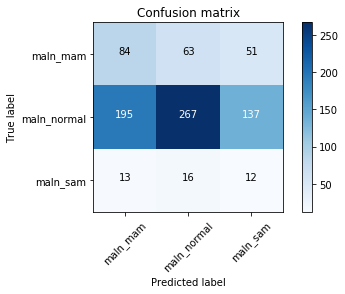

In [24]:
cnf_matrix=confusion_matrix(true_classes, pred_classes)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Model ensembling

In [85]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

In [40]:
model_1=load_model('dense_resnetfeats_32_8(dropout05_upsampled2x)_leakyrelu.h5')
model_2=load_model('dense_resnetfeats_64_32(dropout05_upsampled2x)_leakyrelu.h5')
model_3=load_model('dense_resnetfeats_128_16(dropout05_upsampled2x)_leakyrelu.h5')


In [41]:
prediction_1=model_1.predict(X_test, verbose=1)
prediction_2=model_2.predict(X_test, verbose=1)
prediction_3=model_3.predict(X_test, verbose=1)

838/838 [==============================] - 0s 342us/step


In [42]:
total_pred=np.concatenate((prediction_1, prediction_2,prediction_3), axis=1)
total_target=np.argmax(y_test, axis=1)

In [43]:
## take the mean of hte predicted values
final_pred=[]
for i, prob in enumerate(total_pred):
    class0_mean=np.mean((prob[0],prob[3],prob[6]))
    class1_mean=np.mean((prob[1],prob[4],prob[7]))
    class2_mean=np.mean((prob[2],prob[5],prob[8]))
    mean_pred=[class0_mean, class1_mean, class2_mean]
    final_pred.append(np.argmax(mean_pred))  
    
accuracy_score(total_target, final_pred)    

0.5513126491646778

In [413]:
#take prediction 2
prediction_2_label=np.argmax(prediction_2, axis=1)
prediction_2_label=pd.DataFrame({'single_model_classification':prediction_2_label})
#y_test_labeled
#print(y_test_labeled[3])
label_128_16=pd.DataFrame(prediction_2_label['single_model_classification'].map({0:'mam', 1:'normal', 2:'sam'}))
label_128_16.to_csv('y_test_128_16_pred.csv', index=False)

In [405]:
#final_pred

y_test_labeled=pd.DataFrame({'ensemble_classification':final_pred})
#y_test_labeled
#print(y_test_labeled[3])
y_test_ensemble=pd.DataFrame(y_test_labeled['ensemble_classification'].map({0:'mam', 1:'normal', 2:'sam'}))
y_test_ensemble.to_csv('y_test_ensemble_pred.csv', index=False)

In [24]:
cnf_matrix=confusion_matrix(total_target, final_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

NameError: name 'total_target' is not defined

In [86]:
#try LR
clf = LogisticRegression(random_state=18,class_weight='balanced',tol=0.0001)
clf

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=18,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [93]:
lr_model=clf.fit(total_pred, total_target)

In [94]:
lr_pred = cross_val_predict(clf, total_pred, total_target, cv=5)
accuracy_score(total_target, lr_pred) 

0.6587112171837709

Confusion matrix, without normalization
[[ 23 168   7]
 [ 56 529  14]
 [  6  35   0]]


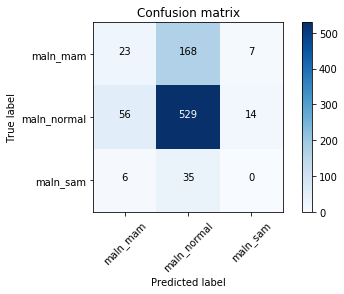

In [108]:
cnf_matrix=confusion_matrix(total_target, lr_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# SVM fit on three models

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [96]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(total_pred, total_target, test_size=0.2, 
                                                        random_state=42, stratify=total_target)


In [97]:
print(x_train_svm.shape)
print(x_test_svm.shape)

(670, 9)
(168, 9)


In [110]:
clf = SVC(C=1.0, kernel='rbf',random_state=18,class_weight='balanced',tol=0.0001)

In [102]:
svm_model=clf.fit(x_train_svm, y_train_svm)

In [103]:
svm_pred=svm_model.predict(x_test_svm)
svm_model.score(x_test_svm, y_test_svm) #accuracy

0.44047619047619047

In [104]:
cv_score = cross_val_score(svm_model, total_pred, total_target, cv=5)
print(cv_score)

[0.3964497  0.39285714 0.45833333 0.29341317 0.43975904]


In [111]:
svm_cv_pred = cross_val_predict(clf, total_pred, total_target, cv=5)
accuracy_score(total_target, svm_cv_pred) 

0.39618138424821003

Confusion matrix, without normalization
[[ 73  46  79]
 [188 251 160]
 [ 21  12   8]]


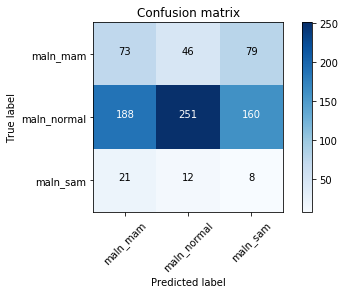

In [113]:
cnf_matrix=confusion_matrix(total_target, svm_cv_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Extra tree

In [114]:
e_tree = ExtraTreesClassifier(n_estimators=40, max_depth=None,min_samples_split=2, max_features=None,
                              random_state=18,class_weight='balanced')

In [115]:
e_tree.fit(x_train_svm, y_train_svm)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=18,
           verbose=0, warm_start=False)

In [60]:
#for stratified validation sample
e_tree_pred=e_tree.predict(x_test_svm)
e_tree.score(x_test_svm, y_test_svm) #accuracy


0.6964285714285714

In [62]:
cv_score = cross_val_score(e_tree, total_pred, total_target, cv=5)
print(cv_score)

[0.65680473 0.625      0.69047619 0.64071856 0.70481928]


In [116]:
etree_cv_pred = cross_val_predict(e_tree, total_pred, total_target, cv=5)
accuracy_score(total_target, etree_cv_pred) 

0.6634844868735084

Confusion matrix, without normalization
[[ 14 183   1]
 [ 54 540   5]
 [  1  38   2]]


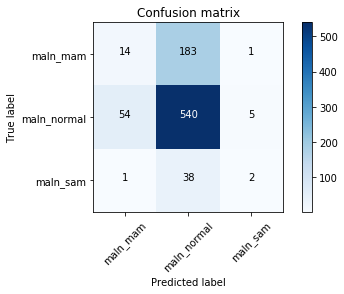

In [117]:
cnf_matrix=confusion_matrix(total_target,etree_cv_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Random Forest did not perform well, it didn't catch the any of the sam class

In [65]:
rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, 
                            class_weight='balanced',random_state=18)

In [66]:
rf.fit(x_train_svm, y_train_svm)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=1, oob_score=False, random_state=18,
            verbose=0, warm_start=False)

In [67]:
#for stratified validation sample
rf_pred=rf.predict(x_test_svm)
rf.score(x_test_svm, y_test_svm) #accuracy


0.6964285714285714

In [69]:
cv_score = cross_val_score(rf, total_pred, total_target, cv=5)
print(cv_score)

[0.67455621 0.64285714 0.7202381  0.65269461 0.71686747]


Confusion matrix, without normalization
[[  6  34   0]
 [  9 111   0]
 [  0   8   0]]


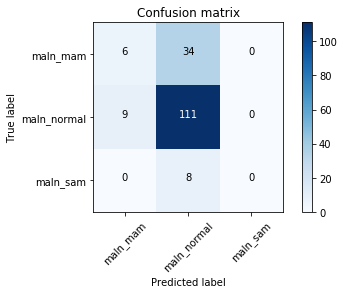

In [70]:
cnf_matrix=confusion_matrix(y_test_svm,rf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

In [325]:
## xgb?
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


In [356]:
xgb = XGBClassifier(objective='multi:softprob', n_estimators=100, subsample=0.7, gamma=2.0,learning_rate=0.001,
                   max_depth=10,random_state=18)


In [357]:
xgb.fit(x_train_svm, y_train_svm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=2.0, learning_rate=0.001,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=18, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [358]:
#for stratified validation sample
xgb_pred=rf.predict(x_test_svm)
xgb.score(x_test_svm, y_test_svm) #accuracy


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7261904761904762

In [359]:
cv_score = cross_val_score(xgb, total_pred_svm, total_target_svm, cv=5)
print(cv_score)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[0.70414201 0.66071429 0.71428571 0.7005988  0.71084337]


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[  7  33   0]
 [  5 115   0]
 [  0   8   0]]


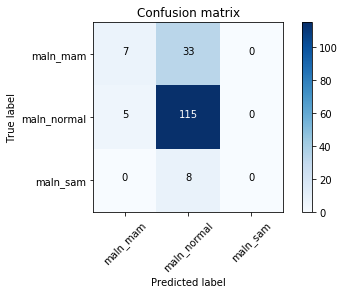

In [360]:
cnf_matrix=confusion_matrix(y_test_svm,xgb_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))